In [18]:
from dataclasses import dataclass
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import joblib

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


In [19]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, header=1)
df.rename(columns={"default payment next month": "default"}, inplace=True)
df.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Análise exploratória (EDA)

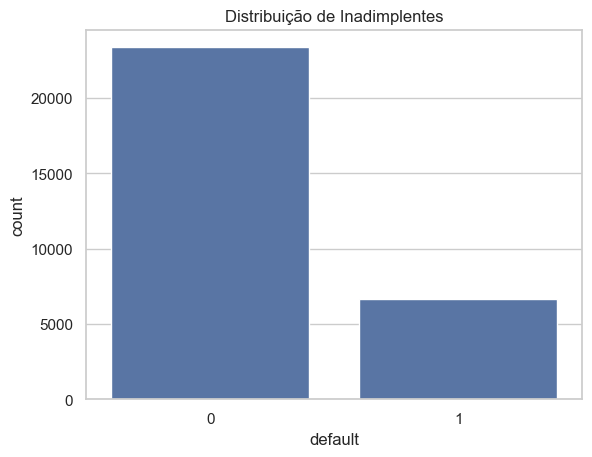

Top correlações com 'default':
default      1.000000
PAY_0        0.324794
PAY_2        0.263551
PAY_3        0.235253
PAY_4        0.216614
PAY_5        0.204149
PAY_6        0.186866
EDUCATION    0.028006
AGE          0.013890
BILL_AMT6   -0.005372
Name: default, dtype: float64


In [20]:
# Distribuição do alvo
sns.countplot(x='default', data=df)
plt.title('Distribuição de Inadimplentes')
plt.show()

# Correlação com a variável alvo
correlations = df.corr(numeric_only=True)['default'].sort_values(ascending=False)
print("Top correlações com 'default':")
print(correlations.head(10))


In [21]:
X = df.drop(columns=['ID', 'default'])
y = df['default']

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)


In [22]:
# Pipeline com SMOTE, escalonamento e XGBoost
pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        tree_method='hist'
    ))
])

# Reduzir o espaço de busca de hiperparâmetros
param_dist = {
    'classifier__n_estimators': randint(100, 500),
    'classifier__max_depth': randint(4, 10),
    'classifier__learning_rate': uniform(0.05, 0.15),
    'classifier__subsample': uniform(0.7, 0.3),
    'classifier__colsample_bytree': uniform(0.7, 0.3),
    'classifier__gamma': uniform(0, 0.3),
    'classifier__min_child_weight': randint(1, 5)
}

# Validação cruzada com menos folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    scoring='accuracy',
    cv=cv,
    n_iter=50,  # Limitar para 50 combinações
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Treinamento do modelo
random_search.fit(X_train, y_train)

# Resultados
print("Melhores parâmetros encontrados:")
print(random_search.best_params_)



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Melhores parâmetros encontrados:
{'classifier__colsample_bytree': np.float64(0.9661638227728979), 'classifier__gamma': np.float64(0.14166447754858477), 'classifier__learning_rate': np.float64(0.06793913689074525), 'classifier__max_depth': 9, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 356, 'classifier__subsample': np.float64(0.916518856349462)}


              precision    recall  f1-score   support

           0       0.85      0.87      0.86      7009
           1       0.50      0.46      0.48      1991

    accuracy                           0.78      9000
   macro avg       0.68      0.66      0.67      9000
weighted avg       0.77      0.78      0.78      9000

ROC AUC: 0.7468


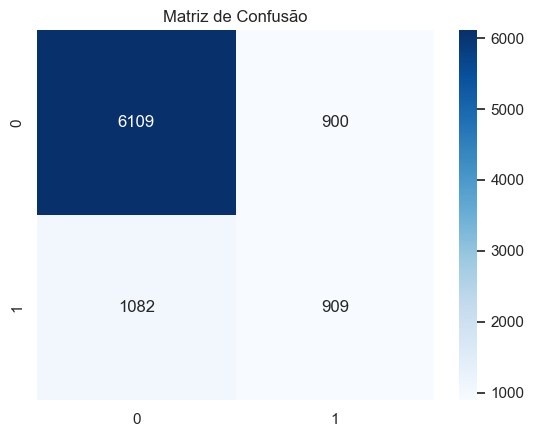

In [23]:
# Avaliação do modelo
y_pred = random_search.predict(X_test)
y_proba = random_search.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Matriz de Confusão
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
import os

# Criar o diretório se não existir
os.makedirs(os.path.join('..', 'models'), exist_ok=True)

# Salvando o modelo
joblib.dump(random_search.best_estimator_, os.path.join('..', 'models', 'modelo_001.pkl'))
print("Modelo salvo com sucesso em '/models/modelo_001.pkl'")

Modelo salvo como 'modelo_001.pkl'
